In [1]:
import torch # pytorch main library 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms # transforms used in the pre-processing of the data
from torchvision.transforms import InterpolationMode
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform
import torch.optim as optim
import time
import os
import copy
import logging
from sklearn.metrics import confusion_matrix
import yaml
import random
from PIL import Image
import pickle

In [10]:
print(os.path.exists('/home/matjaz.cigler1/Project/Models/saved_models/model_lr_0_001_lr_32.pt'))

False


In [12]:
project_directory ='/home/matjaz.cigler1/Project'
model_dir = project_directory + '/Analysis/model_lr_0.001_lr_32'
print(model_dir)
torch.load('/home/matjaz.cigler1/Project/Analysis/model_lr_0_001_lr_32')

/home/matjaz.cigler1/Project/Analysis/model_lr_0.001_lr_32


FileNotFoundError: [Errno 2] No such file or directory: '/home/matjaz.cigler1/Project/Models/saved_models/model_lr_0.001_lr_32'

In [68]:
class_to_ind = {
        'unfertilized': 0,
        '_PKCa': 1,
        'N_KCa': 2,
        'NP_Ca': 3,
        'NPK_': 4,
        'NPKCa': 5,
        'NPKCa+m+s': 6,
    }

def get_metadata(data_root, croptype, split='train'):
    data_path = os.path.join(data_root, croptype, 'images')
    print("Data root path: ".ljust(40), data_path)
    assert os.path.exists(data_path), "{} does not exist, please check your root_path".format(data_path)
    
    # load split
    split_path = os.path.join(data_root, croptype, split)+'.txt'
    with open(split_path, 'r') as f:
        file_names = f.read().splitlines()
        print("Loading split from: ".ljust(40), split_path)

    # load metadata
    labels = None
    if split != 'test':
        metadata_path = os.path.join(data_root, croptype, 'labels_trainval.yml')
        labels_trainval = yaml.safe_load(open(metadata_path, 'r')) # dict, e.g., {20200422_1.jpg: unfertilized, ...}
        print("Loading labels from: ".ljust(40), metadata_path)



    # date of data aquisition
    dates = [file_name.split('_')[0] for file_name in file_names] # e.g. 20200422_0.jpg -> 20200422

    # if verbose:
    #     print("Num of images: ".ljust(40), len(file_paths))
    #     print("Num of labels: ".ljust(40), sum(Counter(labels).values()), len(Counter(labels).values()),Counter(labels))
    #     print("Num of dates: ".ljust(40), sum(Counter(dates).values()), len(Counter(dates).values()),Counter(dates))

    return file_names, labels_trainval, class_to_ind


In [69]:
class StructuredDataset(Dataset):
    def __init__(self, croptype, split = 'train'):
        self.trainval_img_paths, self.trainval_label_names, self.class_to_ind = get_metadata(project_directory, croptype, split)
        self.trainval_label_idxs = [class_to_ind[i] for i in self.label_names] if self.label_names else None

        # use cache for acceleration
        cache_path = os.path.join(project_directory, 'datasets/cache', croptype, str(im_scale))
        print("Cache path: ".ljust(20), cache_path)
        if not os.path.exists(cache_path):
            os.makedirs(cache_path)

        

In [70]:
def train_val_test_split(data, train_proportion, val_proportion):
    total_size = len(data)
    train_size = int(total_size*train_proportion)
    val_size = int(total_size*val_proportion)
    test_size = int(total_size*(1 - train_proportion - val_proportion))

    random.shuffle(data)
    train_set = data[0:train_size]
    val_set = data[train_size: train_size + val_size]
    test_set = data[val_size: val_size + test_size]

    return train_set, val_set, test_set


    

In [81]:
split = 'trainval'
croptype = 'datasets/WR2021'
im_scale = 896
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
trainval_file_names, trainval_labels_dict, class_to_ind = get_metadata(project_directory, croptype, split)
train_files, val_files, test_files = train_val_test_split(trainval_file_names, 0.7, 0.15)

labels = [[], [], []]  # List to hold three lists, one for each set
file_paths = [[], [], []]  # List to hold three lists, one for each set
label_idxs = [[], [], []]  # List to hold three lists, one for each set

# Populate lists for train set
for file_name in train_files:
    labels[0].append(trainval_labels_dict[file_name])
    file_paths[0].append(os.path.join(project_directory, croptype, 'images', file_name))
    label_idxs[0].append(class_to_ind[trainval_labels_dict[file_name]])

# Populate lists for validation set
for file_name in val_files:
    labels[1].append(trainval_labels_dict[file_name])
    file_paths[1].append(os.path.join(project_directory, file_name))
    label_idxs[1].append(class_to_ind[trainval_labels_dict[file_name]])

# Populate lists for test set
for file_name in test_files:
    labels[2].append(trainval_labels_dict[file_name])
    file_paths[2].append(os.path.join(project_directory, file_name))
    label_idxs[2].append(class_to_ind[trainval_labels_dict[file_name]])

# Convert lists to NumPy arrays
labels = [np.array(sublist) for sublist in labels]
file_paths = [np.array(sublist) for sublist in file_paths]
label_idxs = [np.array(sublist) for sublist in label_idxs]


transform = {
    'Train': transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize images to 256x256 using bilinear interpolation
    # transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(256),
    # transforms.RandomRotation(180),
    transforms.ToTensor(),  # Convert images to Tensor
    transforms.Normalize(mean, std)  # CHANGE THESE TO THE TRAINF MEAN ANS STD
    ]),

    'Validation': transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize images to 256x256 using bilinear interpolation
    transforms.CenterCrop(256),
    transforms.ToTensor(),  # Convert images to Tensor
    transforms.Normalize(mean, std)  # CHANGE THESE TO THE TRAINF MEAN ANS STD
    ]),

    'Test': transforms.Compose([
    transforms.Resize(256, interpolation=InterpolationMode.BILINEAR),  # Resize images to 256x256 using bilinear interpolation
    transforms.CenterCrop(256),
    transforms.ToTensor(),  # Convert images to Tensor
    transforms.Normalize(mean, std)  # CHANGE THESE TO THE TRAINF MEAN ANS STD
    ])
}

# Define your custom dataset class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Create datasets
datasets = {
    'Train': CustomDataset(file_paths[0], label_idxs[0], transform['Train']),
    'Validation': CustomDataset(file_paths[1], label_idxs[1], transform['Validation']),
    'Test': CustomDataset(file_paths[2], label_idxs[2], transform['Test'])
}


dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32,
                                             shuffle=(x == 'Train'), num_workers=0)
              for x in ['Train', 'Validation', 'Test']}
dataset_sizes = {x: len(datasets[x]) for x in ['Train', 'Validation', 'Test']}


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

Data root path:                          /home/matjaz.cigler1/645FinalProject/datasets/WR2021/images
Loading split from:                      /home/matjaz.cigler1/645FinalProject/datasets/WR2021/trainval.txt
Loading labels from:                     /home/matjaz.cigler1/645FinalProject/datasets/WR2021/labels_trainval.yml


device(type='cpu')

<function matplotlib.pyplot.show(close=None, block=None)>

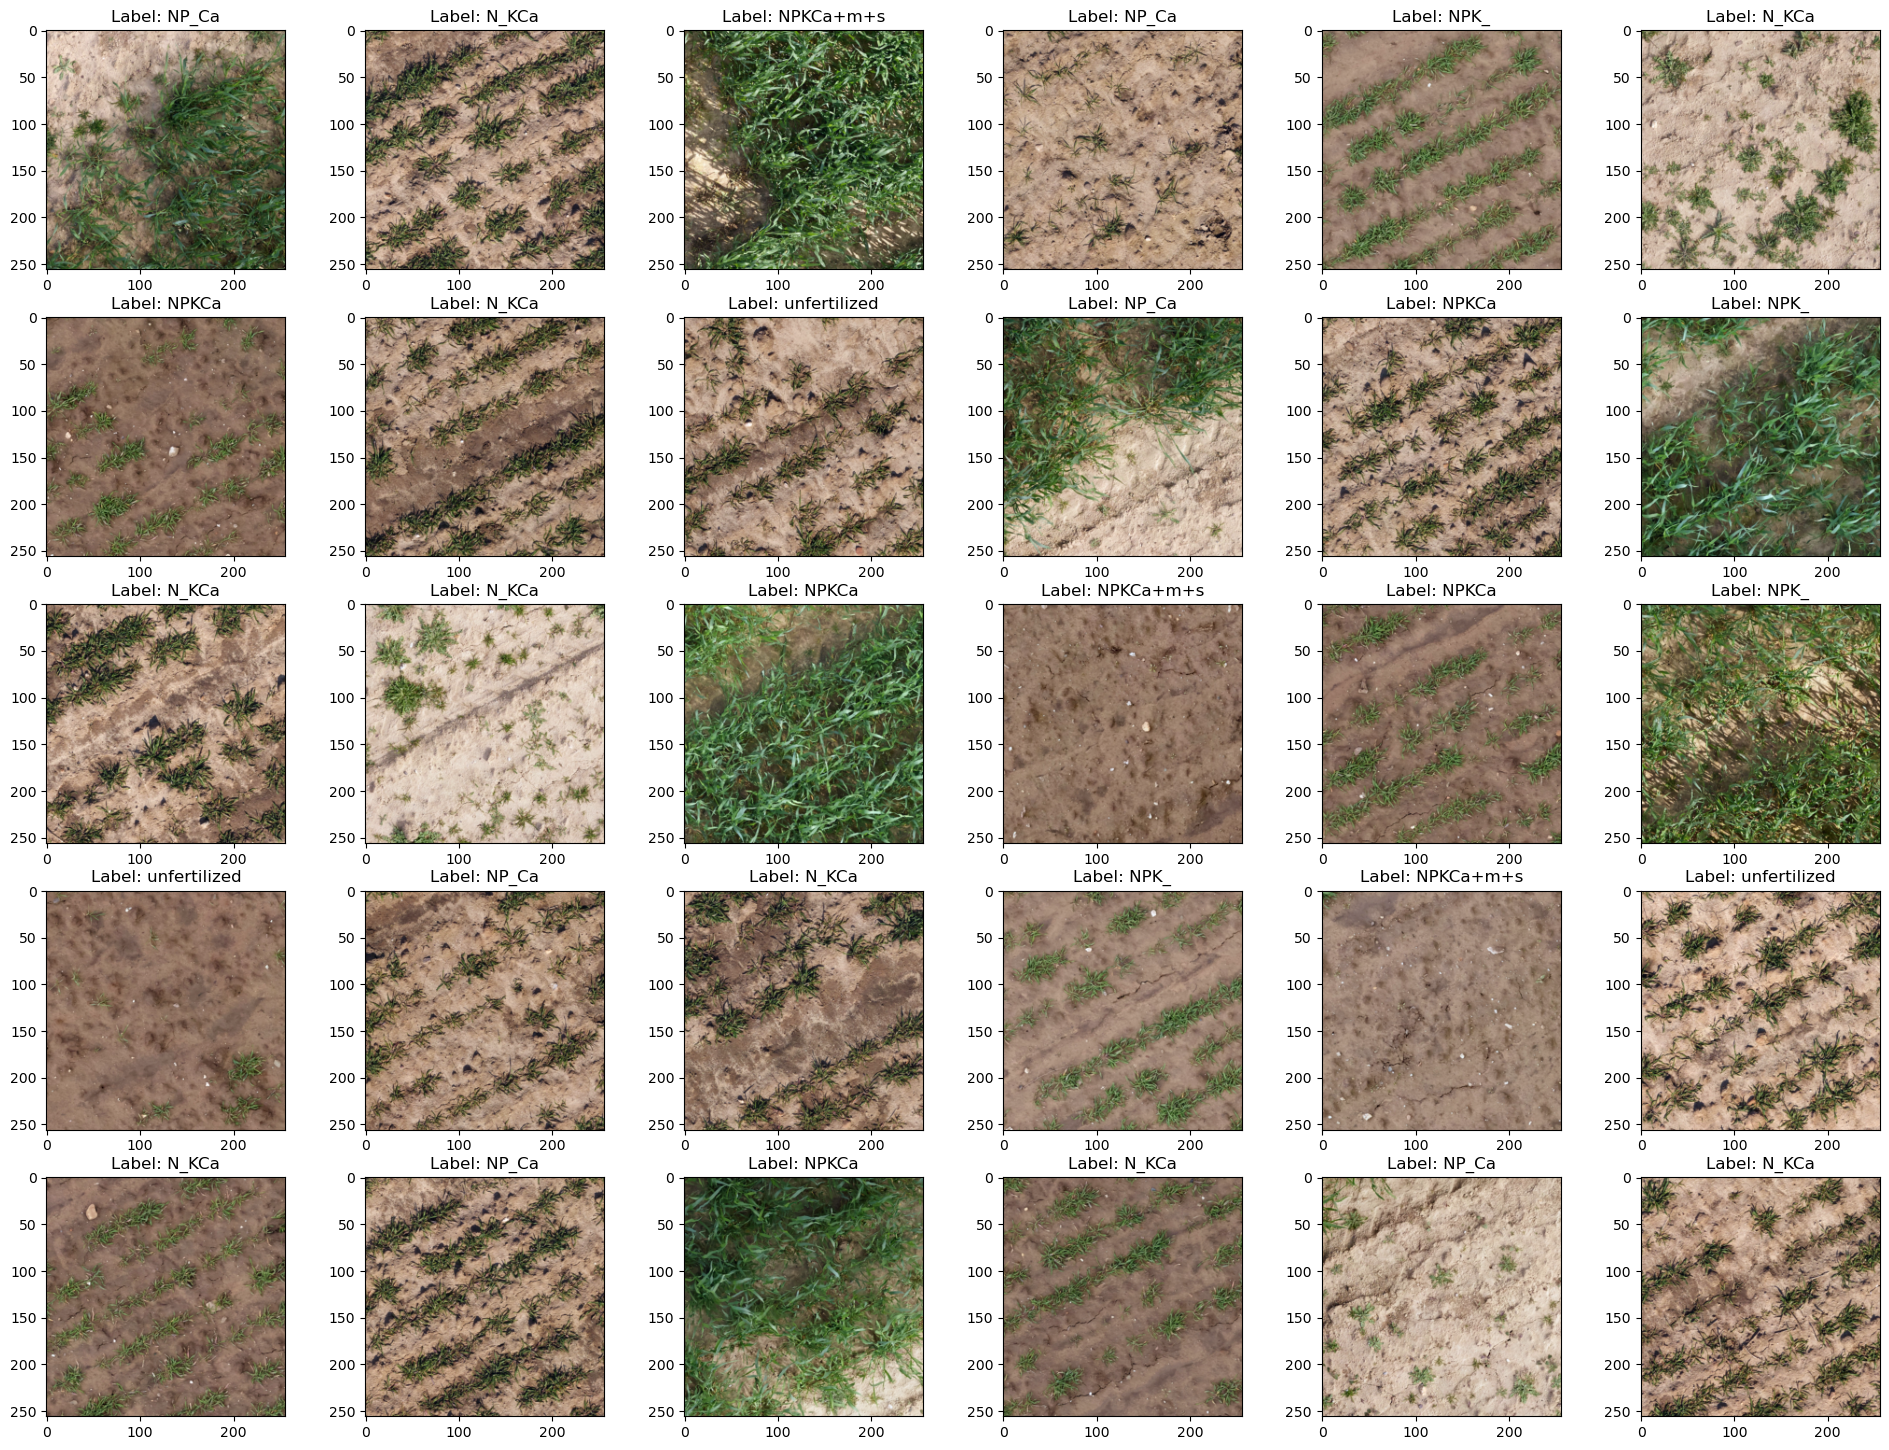

In [85]:
ind_to_class = {v: k for k, v in class_to_ind.items()}
sample_indexes = np.random.choice(len(datasets['Train']),size = 30, replace = False)
plt.figure(figsize= (24, 18))
for(i, j) in enumerate(sample_indexes):
    plt.subplot(5,6, i+1)
    image = datasets['Train'][j][0].numpy()
    image = np.transpose(image, (1, 2, 0))
    max_val = np.max(image)
    min_val = np.min(image)
    image = (image-min_val) / (max_val-min_val)  # Scale pixel values to [0, 1]
    plt.imshow(image)
    plt.title("Label: %s" %ind_to_class[datasets['Train'][j][1]])
plt.show